In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions,plot_xgb_feature_importance


In [4]:
sheet = pd.read_excel('data_input/TA-SC.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['TA-SC（期货指数）'].last_valid_index()
 
future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=21, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()

,TA-SC（期货指数）,RBOB汽油裂解价差（均价）,SC期货指数-Brent原油期货价格,PTA工厂+聚酯工厂原料+仓单库存/月频(预测/国产量最新值/出口两线指标线性拟合/进口季节性/模型2预测聚酯产量)同差,PTA情绪指数/4WMA同差,人民币贬值预期(黄金市场)/5DMA,PTA：原料：中国聚酯工厂：库存可用天数（周）超季节性/3年/4WMA,PTA中国大陆负荷（自动）,中国与美国10年国债利差,聚酯库存+纺织企业原料+成品库存季节性/4WMA,织造订单天数-（原料库存天数+成品库存天数）超季节性/3年,PTA工厂+聚酯工厂原料+仓单库存/月频(预测/产量最新值/进口季节性/出口越南纺织数据一元线性拟合/需求按库存同差拟合
2025-11-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.1501
2025-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# 尝试多个可能的文件路径
file_paths = [
    os.path.expanduser("~/Desktop/X-BASE/宏观经济/eta/中国10年期国债收益率_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/宏观经济/eta/中国10年期国债收益率_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/宏观经济/eta/中国10年期国债收益率_合并数据.xlsx")
]

file_path = None
for path in file_paths:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_path = path
        break

if file_path is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet1 = pd.read_excel(file_path, sheet_name='Sheet1')
    sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
    sheet1 = sheet1.drop(columns=['实际值'])
    sheet1 = sheet1.dropna()
    sheet1 = sheet1.sort_values('Date', ascending=True)
    sheet1.head()
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet1.head()

,Date,中国10年期国债收益率
19,2025-11-03,1.68461
18,2025-11-04,1.68673
17,2025-11-05,1.68885
16,2025-11-06,1.69096
15,2025-11-07,1.69308


In [6]:
# 尝试多个可能的文件路径
file_paths1 = [
    os.path.expanduser("~/Desktop/X-BASE/宏观经济/eta/10年期美国国债收益率_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/宏观经济/eta/10年期美国国债收益率_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/宏观经济/eta/10年期美国国债收益率_合并数据.xlsx")
]

file_path1 = None
for path in file_paths1:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_path1 = path
        break

if file_path1 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet4 = pd.read_excel(file_path1, sheet_name='Sheet1')
    sheet4['Date'] = pd.to_datetime(sheet4['Date'], errors='coerce')
    sheet4 = sheet4.drop(columns=['实际值'])
    sheet4 = sheet4.dropna()
    sheet4 = sheet4.sort_values('Date', ascending=True)
    sheet4.head()
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet4.head()

,Date,10年期美国国债收益率
20,2025-11-03,4.23
19,2025-11-04,4.24
18,2025-11-05,4.25
17,2025-11-06,4.25
16,2025-11-07,4.30


In [7]:
sheet2 = pd.ExcelFile('eta/SC期货指数-Brent原油期货价格_合并数据.xlsx').parse('Sheet1')
sheet2['Date'] = pd.to_datetime(sheet2['Date'], errors='coerce')
sheet2 = sheet2.sort_values('Date', ascending=True)
sheet2 = sheet2.drop(columns=['真实值'])
sheet2 = sheet2.dropna()
sheet2.head()

,Date,预测值
20,2025-11-03,-0.6
19,2025-11-04,-1.1
18,2025-11-05,1.0
17,2025-11-06,0.9
16,2025-11-07,1.8


In [8]:
sheet3 = pd.ExcelFile('eta/RBOB汽油裂解价差（均价）_合并数据.xlsx').parse('Sheet1')
sheet3['Date'] = pd.to_datetime(sheet3['Date'], errors='coerce')
sheet3 = sheet3.sort_values('Date', ascending=True)
sheet3 = sheet3.drop(columns=['真实值'])
sheet3 = sheet3.dropna()
sheet3.head()

,Date,预测值
19,2025-11-03,20.7
18,2025-11-04,20.7
17,2025-11-05,20.7
16,2025-11-06,20.6
15,2025-11-07,20.7


In [9]:
sheet5 = sheet1.copy()
sheet5['中国与美国10年国债利差_预测'] = sheet1['中国10年期国债收益率'] - sheet4['10年期美国国债收益率']
sheet5.head()

,Date,中国10年期国债收益率,中国与美国10年国债利差_预测
19,2025-11-03,1.68461,-2.55539
18,2025-11-04,1.68673,-2.56327
17,2025-11-05,1.68885,-2.56115
16,2025-11-06,1.69096,-2.60904
15,2025-11-07,1.69308,-2.60692


In [10]:
sheet.tail()

,TA-SC（期货指数）,RBOB汽油裂解价差（均价）,SC期货指数-Brent原油期货价格,PTA工厂+聚酯工厂原料+仓单库存/月频(预测/国产量最新值/出口两线指标线性拟合/进口季节性/模型2预测聚酯产量)同差,PTA情绪指数/4WMA同差,人民币贬值预期(黄金市场)/5DMA,PTA：原料：中国聚酯工厂：库存可用天数（周）超季节性/3年/4WMA,PTA中国大陆负荷（自动）,中国与美国10年国债利差,聚酯库存+纺织企业原料+成品库存季节性/4WMA,织造订单天数-（原料库存天数+成品库存天数）超季节性/3年,PTA工厂+聚酯工厂原料+仓单库存/月频(预测/产量最新值/进口季节性/出口越南纺织数据一元线性拟合/需求按库存同差拟合
2025-11-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.1501
2025-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 的美国10年通胀预期数据


sheet_daily = pd.merge(
    sheet_daily,
    sheet2[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['SC期货指数-Brent原油期货价格'] = sheet_daily['SC期货指数-Brent原油期货价格'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])

sheet_daily = pd.merge(
    sheet_daily,
    sheet3[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['RBOB汽油裂解价差（均价）'] = sheet_daily['RBOB汽油裂解价差（均价）'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])

sheet_daily = pd.merge(
    sheet_daily,
    sheet5[['Date', '中国与美国10年国债利差_预测']],
    on='Date',
    how='left'
)
sheet_daily['中国与美国10年国债利差'] = sheet_daily['中国与美国10年国债利差'].fillna(sheet_daily['中国与美国10年国债利差_预测'])
sheet_daily = sheet_daily.drop(columns=['中国与美国10年国债利差_预测'])

# 将 sheet_daily 重新赋值给 sheet
sheet = sheet_daily.copy()
sheet = sheet.set_index('Date')

In [12]:
sheet.columns

Index(['TA-SC（期货指数）', 'RBOB汽油裂解价差（均价）', 'SC期货指数-Brent原油期货价格',
       'PTA工厂+聚酯工厂原料+仓单库存/月频(预测/国产量最新值/出口两线指标线性拟合/进口季节性/模型2预测聚酯产量)同差',
       'PTA情绪指数/4WMA同差', '人民币贬值预期(黄金市场)/5DMA',
       'PTA：原料：中国聚酯工厂：库存可用天数（周）超季节性/3年/4WMA', 'PTA中国大陆负荷（自动）', '中国与美国10年国债利差',
       '聚酯库存+纺织企业原料+成品库存季节性/4WMA', '织造订单天数-（原料库存天数+成品库存天数）超季节性/3年',
       'PTA工厂+聚酯工厂原料+仓单库存/月频(预测/产量最新值/进口季节性/出口越南纺织数据一元线性拟合/需求按库存同差拟合'],
      dtype='object')

In [13]:
################################# 处理缺失值 #################################
fill_methods = {
'RBOB汽油裂解价差（均价）': 'interpolate', 
'SC期货指数-Brent原油期货价格': 'interpolate',
'PTA工厂+聚酯工厂原料+仓单库存/月频(预测/国产量最新值/出口两线指标线性拟合/进口季节性/模型2预测聚酯产量)同差': 'interpolate',
'PTA情绪指数/4WMA同差': 'interpolate', 
'人民币贬值预期(黄金市场)/5DMA': 'interpolate',
'PTA：原料：中国聚酯工厂：库存可用天数（周）超季节性/3年/4WMA': 'interpolate',
'PTA中国大陆负荷（自动）': 'interpolate',
'中国与美国10年国债利差': 'interpolate',
'聚酯库存+纺织企业原料+成品库存季节性/4WMA': 'interpolate', 
'织造订单天数-（原料库存天数+成品库存天数）超季节性/3年': 'interpolate',
'PTA工厂+聚酯工厂原料+仓单库存/月频(预测/产量最新值/进口季节性/出口越南纺织数据一元线性拟合/需求按库存同差拟合': 'interpolate',
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
#sheet.loc[:last_day, '汽油出口利润（华东-新加坡）'] = sheet.loc[:last_day, '汽油出口利润（华东-新加坡）'].interpolate(method='linear')

#################################  因子处理  #################################

sheet['RBOB汽油裂解价差（均价）_提前10天'] = sheet['RBOB汽油裂解价差（均价）'].shift(10)
sheet['PTA情绪指数/4WMA同差_提前20天'] = sheet['PTA情绪指数/4WMA同差'].shift(20)
sheet['人民币贬值预期(黄金市场)/5DMA_提前20天'] = sheet['人民币贬值预期(黄金市场)/5DMA'].shift(20)
sheet['PTA：原料：中国聚酯工厂：库存可用天数（周）超季节性/3年/4WMA_提前35天'] = sheet['PTA：原料：中国聚酯工厂：库存可用天数（周）超季节性/3年/4WMA'].shift(35)
sheet['PTA中国大陆负荷（自动）_提前20天'] = sheet['PTA中国大陆负荷（自动）'].shift(20)
sheet['聚酯库存+纺织企业原料+成品库存季节性/4WMA_提前20天'] = sheet['聚酯库存+纺织企业原料+成品库存季节性/4WMA'].shift(20)
sheet['织造订单天数-（原料库存天数+成品库存天数）超季节性/3年_提前70天'] = sheet['织造订单天数-（原料库存天数+成品库存天数）超季节性/3年'].shift(70)


sheet['SC期货指数-Brent原油期货价格_逆序'] = reverse_column(sheet, 'SC期货指数-Brent原油期货价格')
sheet['PTA工厂+聚酯工厂原料+仓单库存/月频(预测/国产量最新值/出口两线指标线性拟合/进口季节性/模型2预测聚酯产量)同差_逆序'] = reverse_column(sheet, 'PTA工厂+聚酯工厂原料+仓单库存/月频(预测/国产量最新值/出口两线指标线性拟合/进口季节性/模型2预测聚酯产量)同差')
sheet['PTA情绪指数/4WMA同差_提前20天_逆序'] = reverse_column(sheet, 'PTA情绪指数/4WMA同差_提前20天')
sheet['PTA：原料：中国聚酯工厂：库存可用天数（周）超季节性/3年/4WMA_提前35天_逆序'] = reverse_column(sheet, 'PTA：原料：中国聚酯工厂：库存可用天数（周）超季节性/3年/4WMA_提前35天')
sheet['PTA中国大陆负荷（自动）_提前20天_逆序'] = reverse_column(sheet, 'PTA中国大陆负荷（自动）_提前20天')
sheet['PTA工厂+聚酯工厂原料+仓单库存/月频(预测/产量最新值/进口季节性/出口越南纺织数据一元线性拟合/需求按库存同差拟合_逆序'] = reverse_column(sheet, 'PTA工厂+聚酯工厂原料+仓单库存/月频(预测/产量最新值/进口季节性/出口越南纺织数据一元线性拟合/需求按库存同差拟合')

sheet['SC期货指数-Brent原油期货价格_逆序'] = sheet['SC期货指数-Brent原油期货价格_逆序'].rolling(window=5, min_periods=1).mean()
sheet['人民币贬值预期(黄金市场)/5DMA_提前20天'] = sheet['人民币贬值预期(黄金市场)/5DMA_提前20天'].rolling(window=5, min_periods=1).mean()
################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-01-01')]

sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['TA-SC（期货指数）'].notna())
]

################################# 数据 读取-处理 结束 #################################

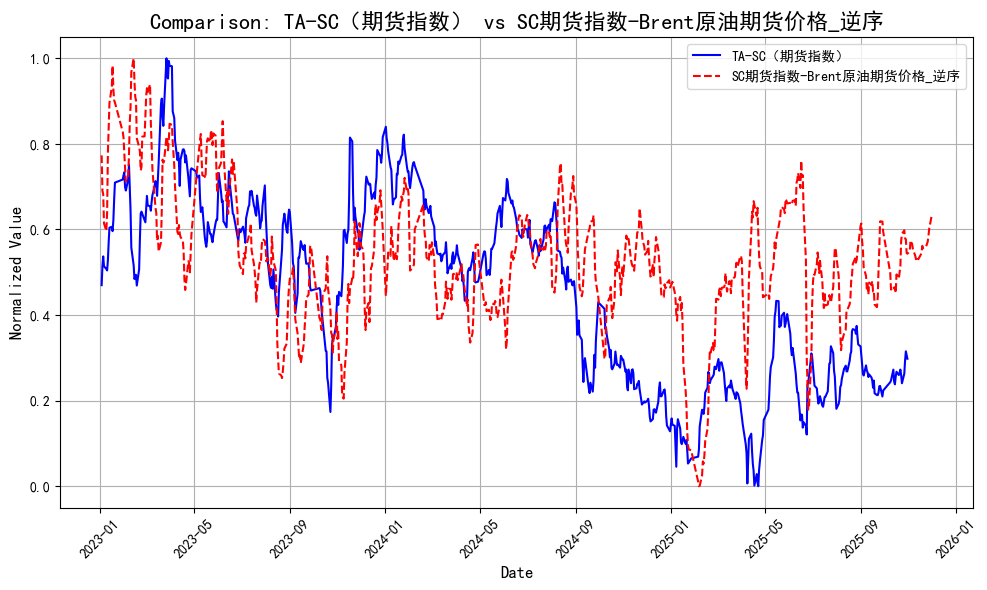

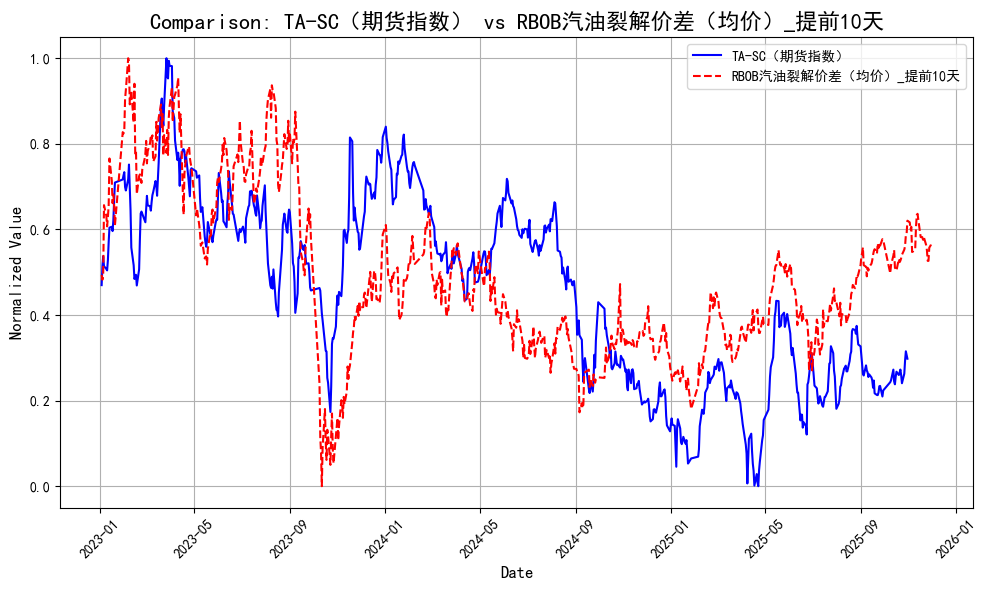

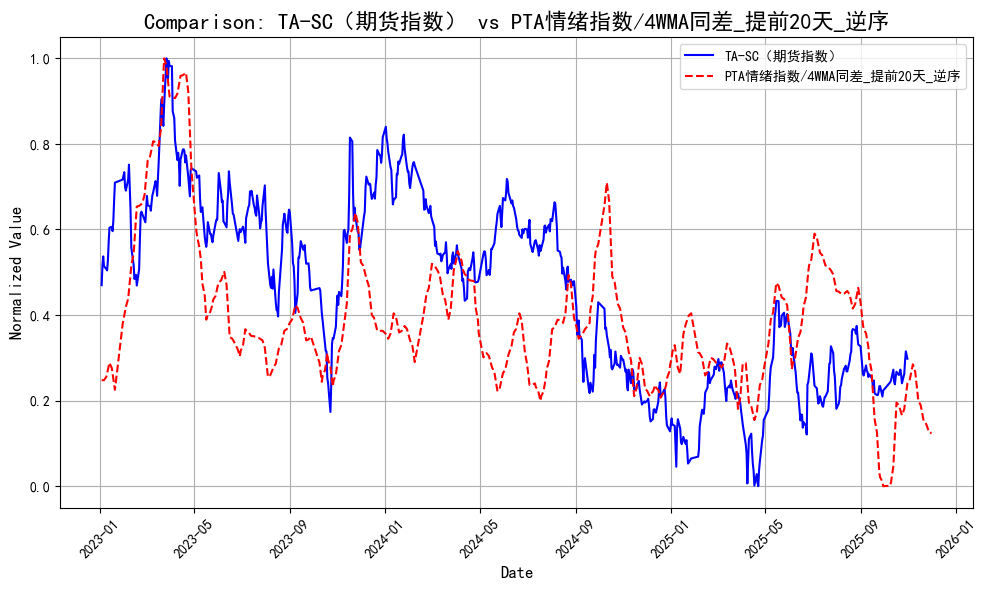

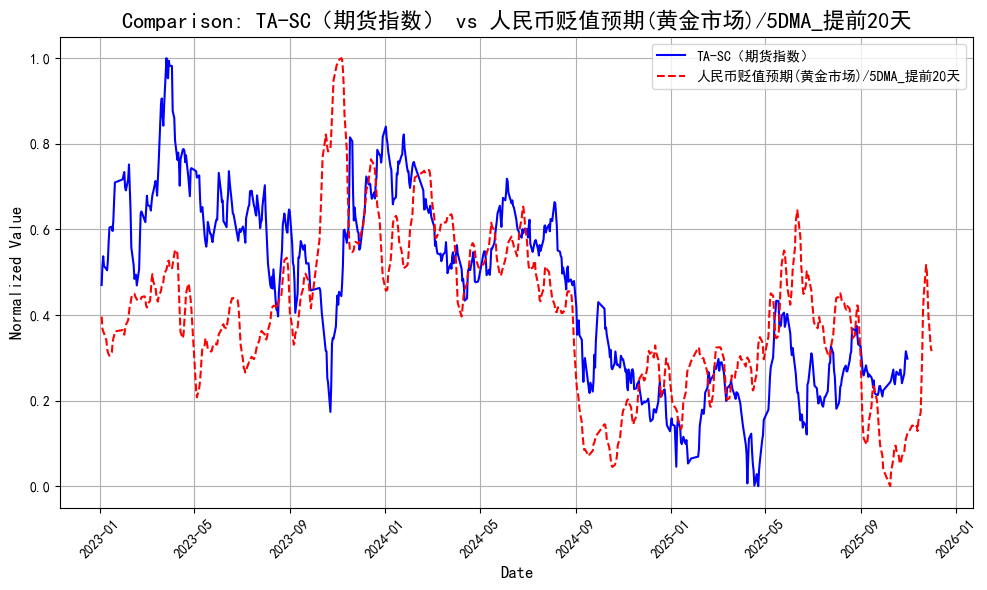

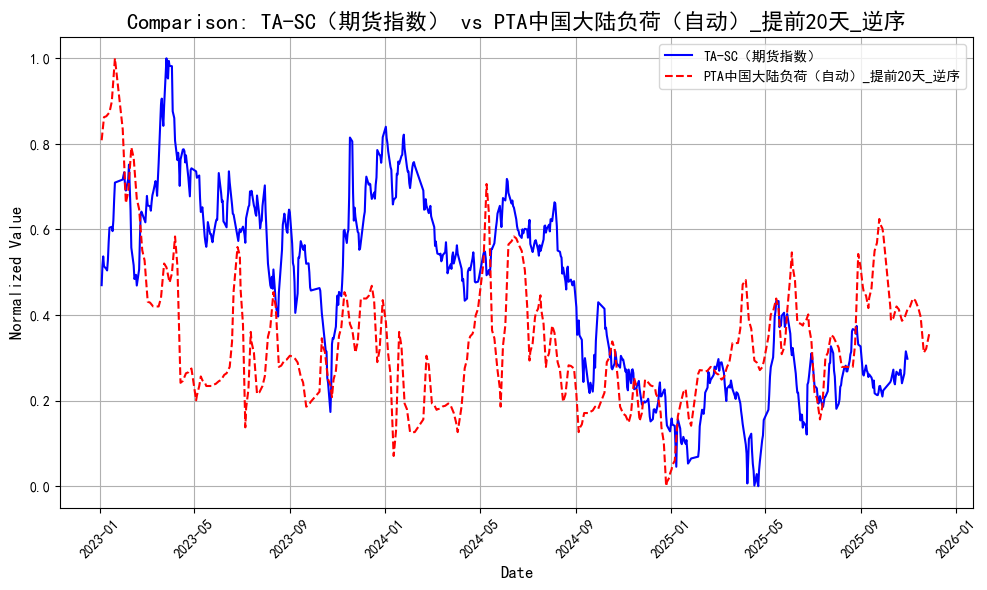

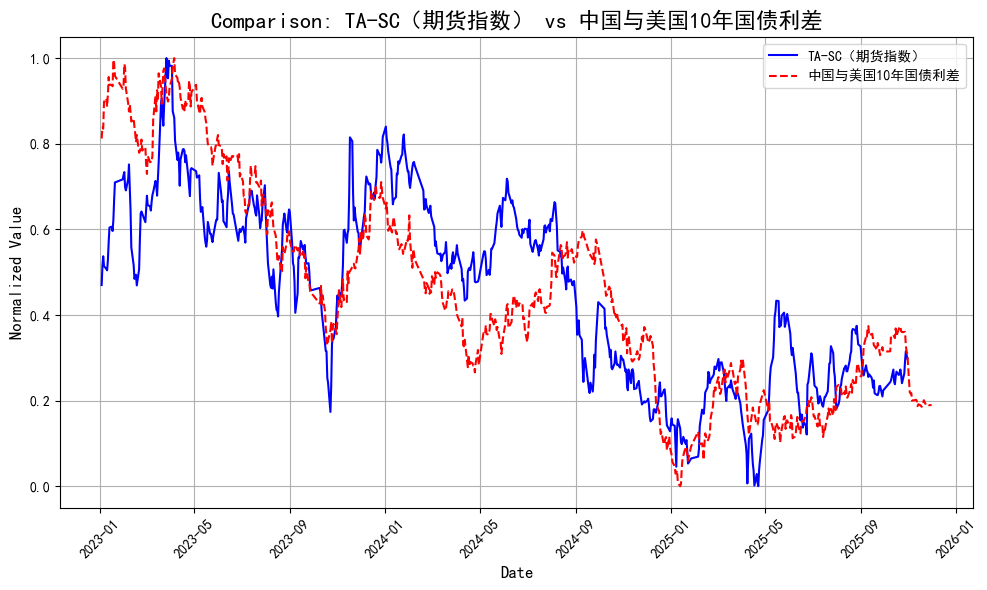

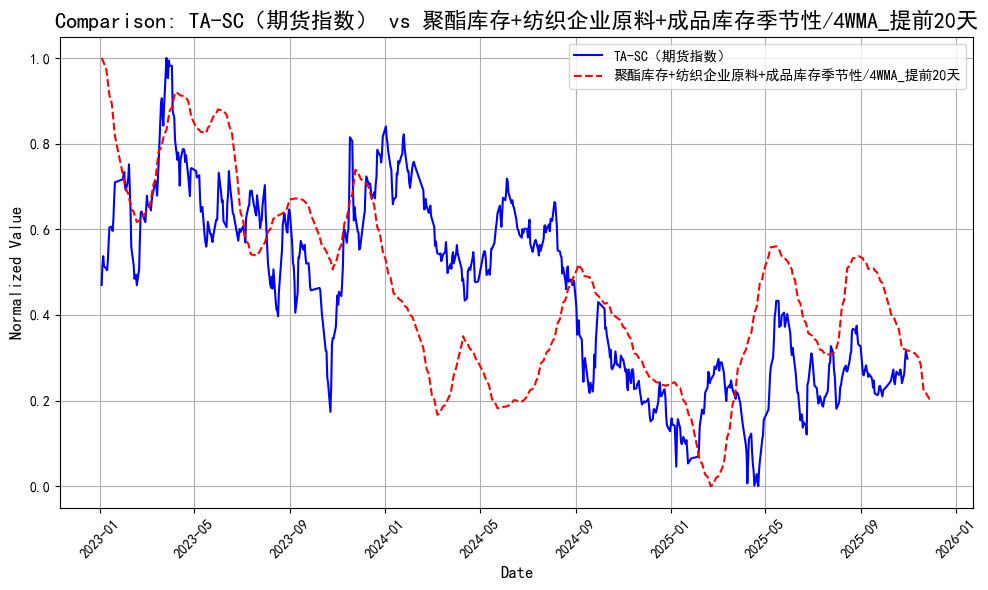

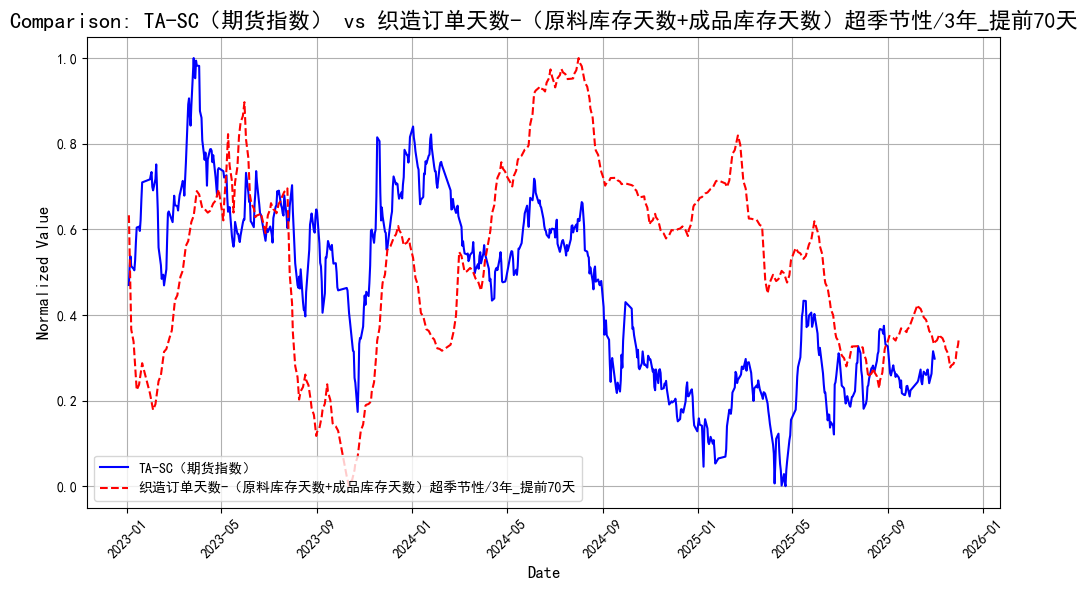

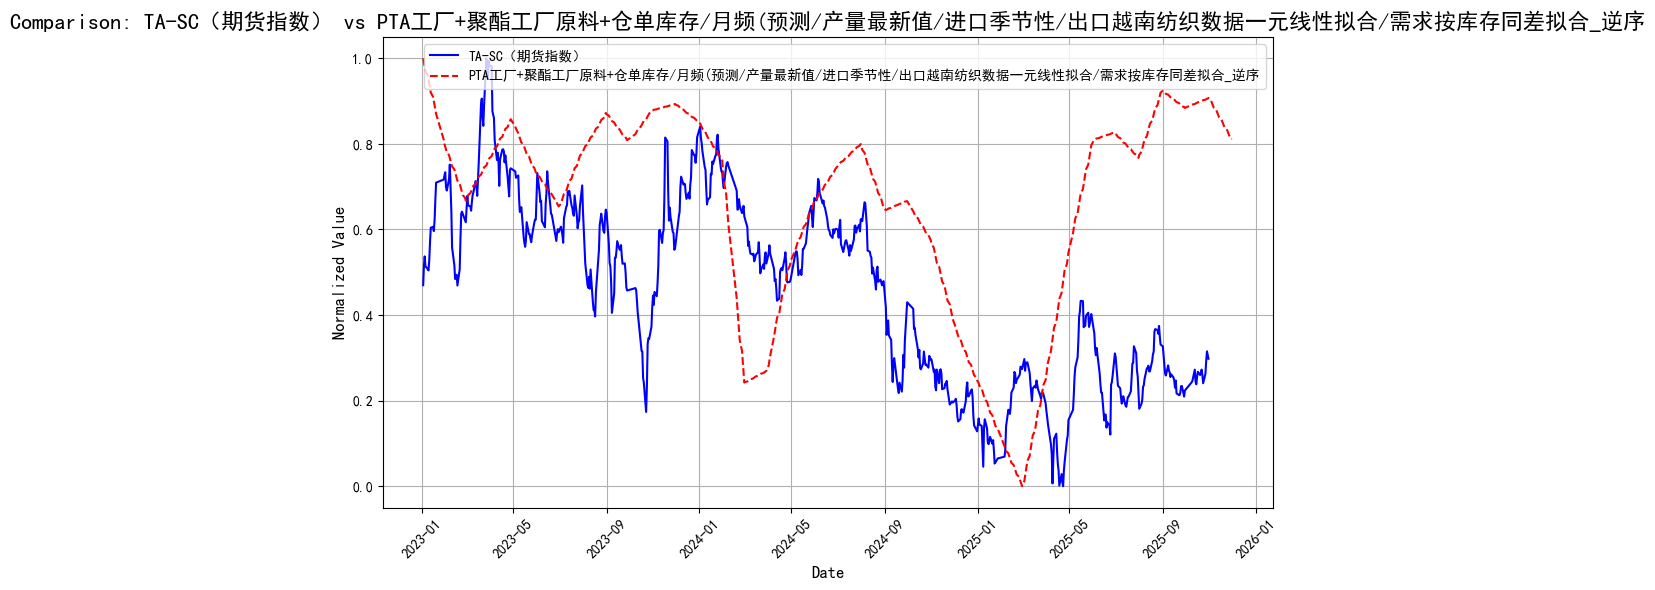

In [14]:
sheet_daily_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='TA-SC（期货指数）', 
    compare_cols=[
        'SC期货指数-Brent原油期货价格_逆序',
        'RBOB汽油裂解价差（均价）_提前10天',
        #'PTA工厂+聚酯工厂原料+仓单库存/月频(预测/国产量最新值/出口两线指标线性拟合/进口季节性/模型2预测聚酯产量)同差_逆序',
        'PTA情绪指数/4WMA同差_提前20天_逆序',
        '人民币贬值预期(黄金市场)/5DMA_提前20天',
        # 'PTA：原料：中国聚酯工厂：库存可用天数（周）超季节性/3年/4WMA_提前35天_逆序',
        'PTA中国大陆负荷（自动）_提前20天_逆序',
        '中国与美国10年国债利差',
        '聚酯库存+纺织企业原料+成品库存季节性/4WMA_提前20天',
        '织造订单天数-（原料库存天数+成品库存天数）超季节性/3年_提前70天',
        'PTA工厂+聚酯工厂原料+仓单库存/月频(预测/产量最新值/进口季节性/出口越南纺织数据一元线性拟合/需求按库存同差拟合_逆序'
        ]
)

In [15]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 20
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
        'SC期货指数-Brent原油期货价格_逆序',
        'RBOB汽油裂解价差（均价）_提前10天',
#        'PTA工厂+聚酯工厂原料+仓单库存/月频(预测/国产量最新值/出口两线指标线性拟合/进口季节性/模型2预测聚酯产量)同差_逆序',
        'PTA情绪指数/4WMA同差_提前20天_逆序',
        '人民币贬值预期(黄金市场)/5DMA_提前20天',
#        'PTA：原料：中国聚酯工厂：库存可用天数（周）超季节性/3年/4WMA_提前35天_逆序',
        'PTA中国大陆负荷（自动）_提前20天_逆序',
        '中国与美国10年国债利差',
        '聚酯库存+纺织企业原料+成品库存季节性/4WMA_提前20天',
        '织造订单天数-（原料库存天数+成品库存天数）超季节性/3年_提前70天',
        'PTA工厂+聚酯工厂原料+仓单库存/月频(预测/产量最新值/进口季节性/出口越南纺织数据一元线性拟合/需求按库存同差拟合_逆序'
]

predict_column = 'TA-SC（期货指数）'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 85)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.007,  # 默认学习率
    'max_depth': 7,  # 默认树深度
    'min_child_weight': 6,  # 默认最小子节点权重
    'subsample': 0.8,  # 默认子采样比例
    'colsample_bytree': 0.8,  # 默认特征采样比例
    'gamma': 1,  # 默认最小分裂损失
    'reg_alpha': 0.5,  # 默认L1正则化
    'reg_lambda': 1.5,  # 默认L2正则化
    'eval_metric': 'rmse',  # 评估指标
    'seed': 42,  # 随机种子
#    'tree_method': 'auto'  # 默认树方法
}


num_boost_round = 500
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=100,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=500 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:311.41637	train-rmse:313.80973


[499]	eval-rmse:34.25188	train-rmse:35.71410


训练集 MSE (DMatrix): 1433.127, 训练集 R² (DMatrix): 0.9866
测试集 MSE (DMatrix): 1173.1919, 测试集 R² (DMatrix): 0.2938


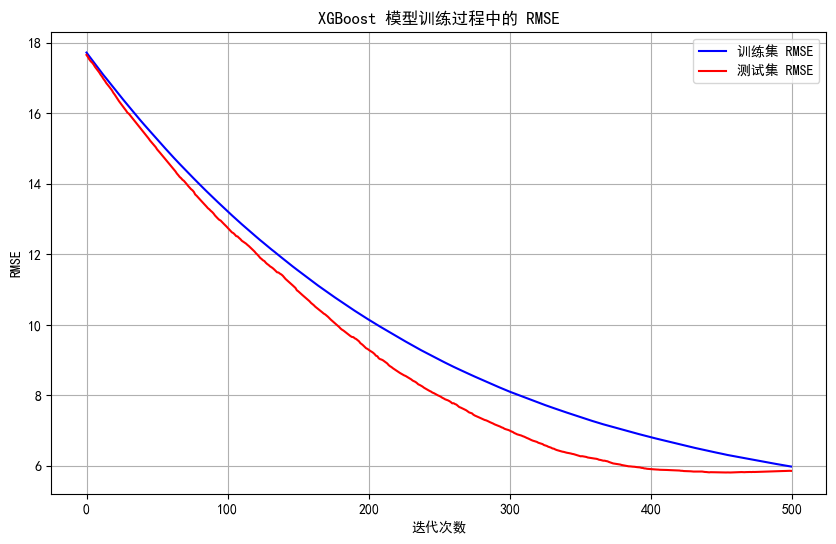

In [16]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重

# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=500
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:313.63717


[499]	train-rmse:35.56021


全部数据 MSE: 1427.2394, 全部数据 R²: 0.9866


Gap between last actual value and first prediction: 12.119790039062536


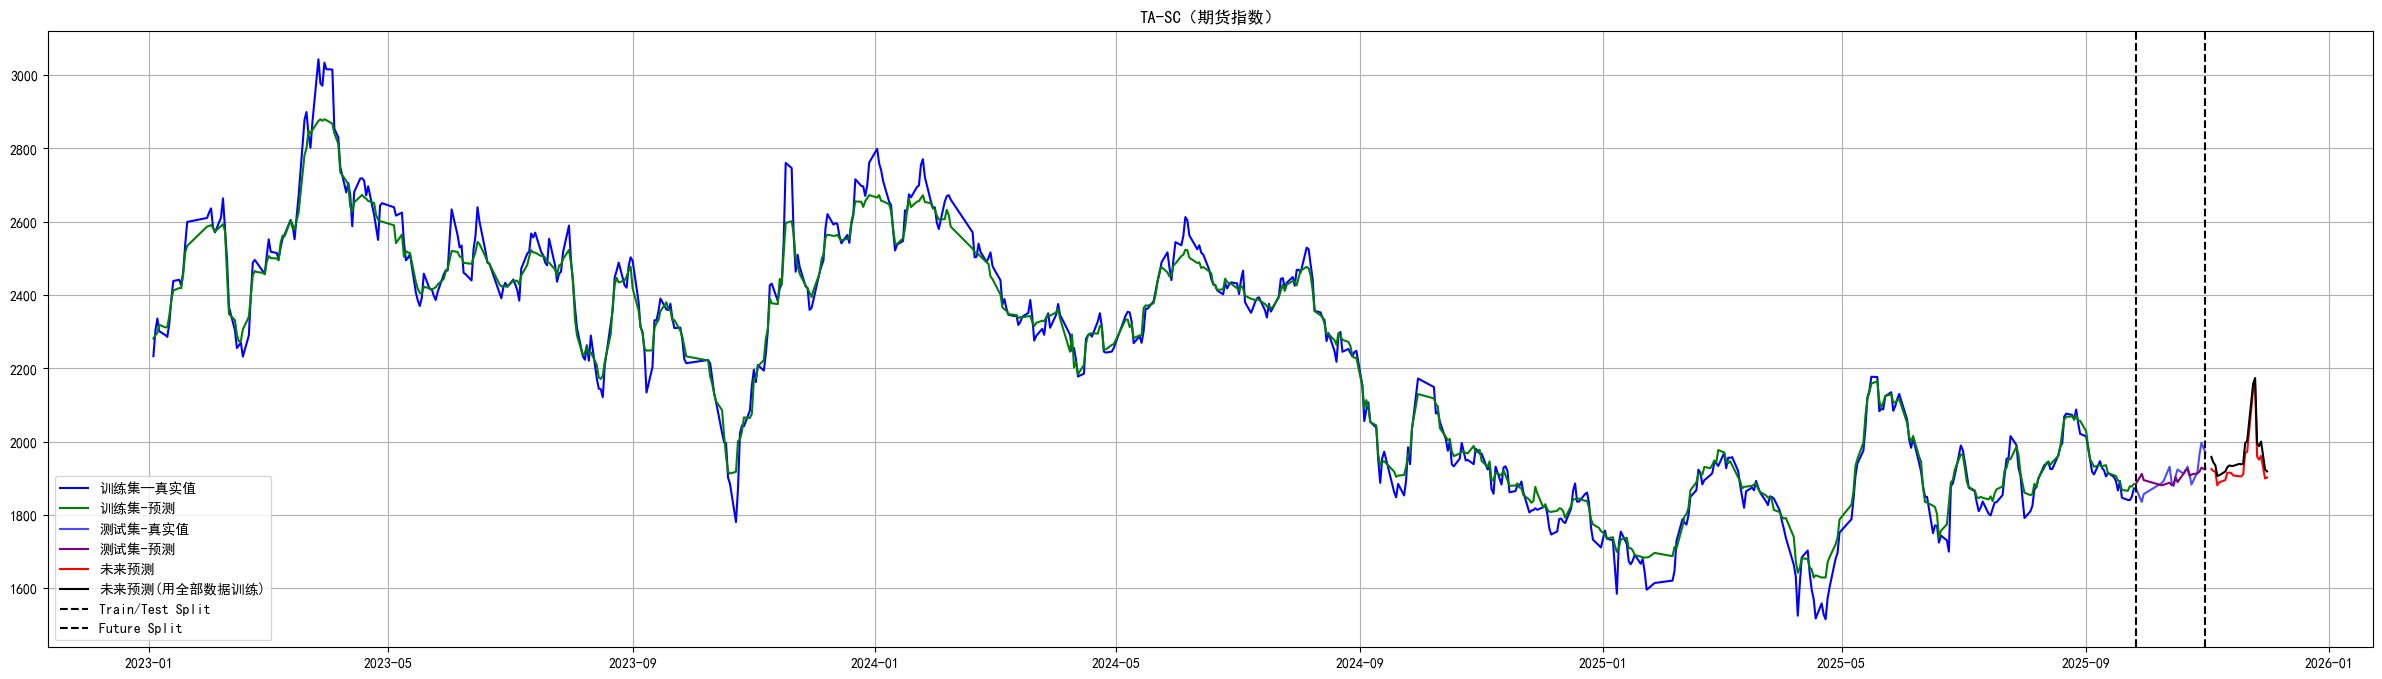

In [18]:
plt.figure(figsize=(30, 8))
# 绘制主要数据
future_data = plot_predictions(y_test, future_data, col=True, label=True)
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('TA-SC（期货指数）')
plt.legend()
plt.grid(True)
plt.show()

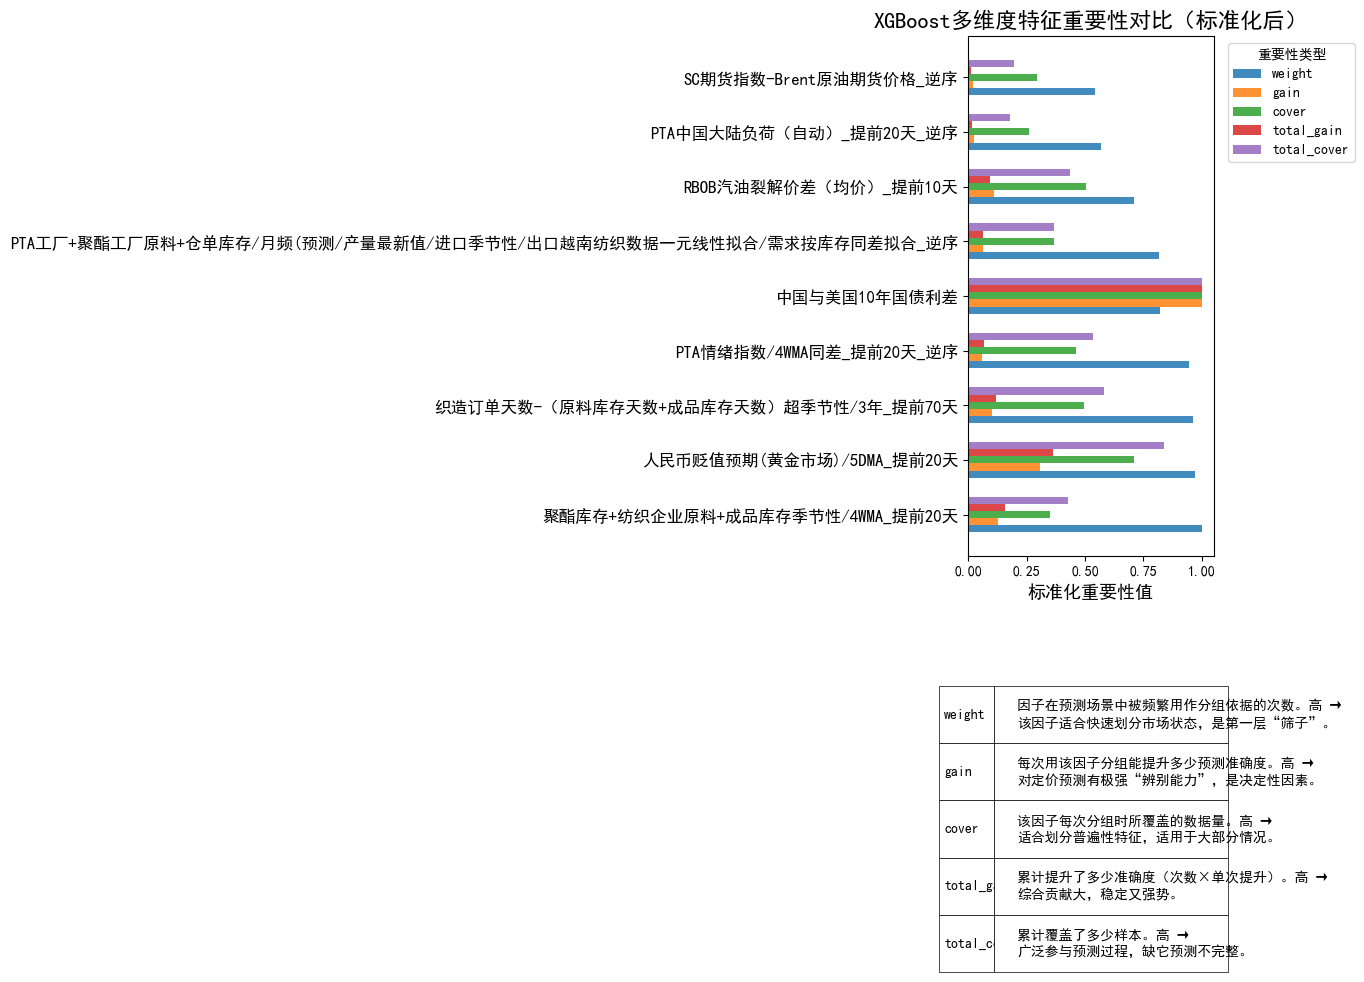

,weight,gain,cover,total_gain,total_cover
聚酯库存+纺织企业原料+成品库存季节性/4WMA_提前20天,1.000000,0.129849,0.351122,0.158237,0.427887
人民币贬值预期(黄金市场)/5DMA_提前20天,0.969759,0.307466,0.709764,0.363355,0.838780
织造订单天数-（原料库存天数+成品库存天数）超季节性/3年_提前70天,0.961177,0.101175,0.494696,0.118508,0.579445
PTA情绪指数/4WMA同差_提前20天_逆序,0.946465,0.058028,0.463051,0.066929,0.534077
中国与美国10年国债利差,0.820597,1.000000,1.000000,1.000000,1.000000
PTA工厂+聚酯工厂原料+仓单库存/月频(预测/产量最新值/进口季节性/出口越南纺织数据一元线性拟合/需求按库存同差拟合_逆序,0.818145,0.062069,0.369344,0.061883,0.368241
RBOB汽油裂解价差（均价）_提前10天,0.709031,0.108733,0.504110,0.093950,0.435573
PTA中国大陆负荷（自动）_提前20天_逆序,0.567634,0.024569,0.259968,0.016995,0.179829
SC期货指数-Brent原油期货价格_逆序,0.542705,0.020364,0.295030,0.013468,0.195120


In [19]:
#绘制因子重要性
plot_xgb_feature_importance(model_all, X_train)

In [20]:
################################# 训练预测数据 excel格式输出  #################################
'''
1. 日度数据 （真实值 和 预测值）
2. 月度数据 （真实值、训练值、预测值）
'''

############ 日度 数据 ############
# 创建日度数据框
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 只保留2023年之后的数据
historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
# 创建预测数据框
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})


merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/TA-SC_合并数据.xlsx', index=False,float_format='%.1f')

merged_df_daily

,Date,真实值,预测值
705,2025/12/01,NaN,1918.925903
704,2025/11/30,NaN,1924.447021
703,2025/11/28,NaN,2000.687622
702,2025/11/27,NaN,1988.120361
701,2025/11/26,NaN,1996.035767
...,...,...,...
4,2023/01/09,2290.97,NaN
3,2023/01/06,2301.09,NaN
2,2023/01/05,2336.11,NaN
1,2023/01/04,2302.08,NaN


In [21]:
############ 月度 数据 ############
# 历史真实值
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 真实数据 只保留2023年之后的
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2024]
# 2024年及以后训练集预测值
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
# 2024年及以后c测试集集预测值
test_pred_2024 = test_data[['Date', '预测值']].copy()
# 未来预测值 
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并 训练集预测+测试集预测+未来预测
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

# 合并历史真实值和预测值
merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_df_monthly = merged_df_monthly.dropna(subset=['真实值', '预测值'], how='all')
merged_df_monthly.to_excel('eta/TA-SC_月度数据.xlsx', index=False, float_format='%.1f')
merged_df_monthly.head()

,Date,真实值,预测值
23,2025/12/31,NaN,1918.925903
22,2025/11/30,NaN,1969.607544
21,2025/10/31,1923.818824,1906.013672
20,2025/09/30,1898.669091,1916.624268
19,2025/08/31,1958.497619,1969.070312


In [22]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "TA-SC（期货指数）"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [23]:
from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "TA-SC（期货指数）"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")


数据过滤完成: 保留 24 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
